In [1]:
cd

/Users/keith_tetrad


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import FlowCal
import flowutils
import os
import matplotlib.ticker as mtick
from matplotlib.patches import Patch

In [3]:
# Logicle transform (linear near 0, log for the rest)

def logicle_transform(df, column_name):
    transformed_array = np.array(df[column_name]) 
    transformed_array = flowutils.transforms.logicle(transformed_array, None)
    df[column_name] = transformed_array
    return df

In [4]:
def process_fcs_file(filepath):
    # Ensure the file exists
    if not os.path.exists(filepath):
        print("File not found:", filepath)
        return None

    # Read and transform the FCS data
    fcs_data = FlowCal.io.FCSData(filepath)
    fcs_data = FlowCal.transform.to_rfi(fcs_data)

    # Extract the sample_name from the filename
    sample_name = "_".join(os.path.basename(filepath).split("_")[1:3])

    # Add the identifier
    identifier = np.full(shape=(fcs_data.shape[0], 1), fill_value=sample_name)
    combined_data = np.hstack((fcs_data, identifier))

    # Convert to DataFrame
    combined_data_df = pd.DataFrame(combined_data, columns=list(fcs_data.channels) + ["sample_name"])
    combined_data_df.iloc[:, :-1] = combined_data_df.iloc[:, :-1].apply(pd.to_numeric)

    # Apply logicle transformation
    combined_data_df = logicle_transform(combined_data_df, "530_30 Blue B-A")
    combined_data_df = logicle_transform(combined_data_df, "610_20 YG D-A")

    return combined_data_df

def add_files_to_dict(directory):
    files_dict = {}
    for file in os.listdir(directory):
        if file.endswith(".fcs"):  # Checking if the file is an FCS file
            filepath = os.path.join(directory, file)
            sample_name = "_".join(file.split("_")[1:3])  # Extract 'sample_name' from filename
            processed_file = process_fcs_file(filepath)

            # Check if the processed file has more than 5000 rows
            if processed_file.shape[0] > 5000:
                files_dict[sample_name] = processed_file

    return files_dict

directory = 'UPR_drug_spike_expression/data/20231220 FlowJo'
files_dictionary = add_files_to_dict(directory)
files_dictionary = dict(sorted(files_dictionary.items(), key=lambda item: int(item[0].split('_')[1])))
# Now files_dictionary contains only the processed data with more than 5000 rows, with codes as keys


MetaData = pd.read_csv('UPR_drug_spike_expression/data/20231214_metadata.csv')

combined_data_dict = {}

for key, df in files_dictionary.items():
    combined_data = pd.merge(df, MetaData, on="sample_name")
    combined_data = combined_data.rename(columns={"530_30 Blue B-A": "FITC (a.u.)"})
    combined_data = combined_data.rename(columns={"610_20 YG D-A": "mCherry (a.u.)"})
    combined_data['Normalized (a.u.)'] = combined_data['FITC (a.u.)']-combined_data['mCherry (a.u.)']
    combined_data_dict[key] = combined_data
       

In [5]:
# Initialize an empty DataFrame to store aggregated statistics for each sample.
# The DataFrame will include median and standard error of the mean (SEM) for mCherry and FITC signals.
summary_df = pd.DataFrame(columns=[
    'sample_name', 'cell_line', 'drug', 'secondary',
    'median_mCherry', 'sem_mCherry', 'median_FITC', 'sem_FITC'
])

# Process and aggregate data from each sample DataFrame stored in combined_data_dict.
for df in combined_data_dict.values():
    # Calculate median values and SEM for mCherry and FITC signals.
    df['median_mCherry'] = df['mCherry (a.u.)'].median()
    df['sem_mCherry'] = df['mCherry (a.u.)'].sem()  # SEM for mCherry
    df['median_FITC'] = df['FITC (a.u.)'].median()
    df['sem_FITC'] = df['FITC (a.u.)'].sem()  # SEM for FITC

    # Select relevant columns and remove duplicate entries.
    selected_columns = df[['sample_name', 'cell_line', 'drug', 'secondary', 
                           'median_mCherry', 'sem_mCherry', 'median_FITC', 'sem_FITC']].drop_duplicates()

    # Append these columns to the summary DataFrame for a comprehensive summary.
    summary_df = pd.concat([summary_df, selected_columns], ignore_index=True)

# Filter out samples marked as 'unlabel' in the 'secondary' column.
summary_df = summary_df[summary_df['secondary'] != 'unlabel']
    
# Function to calculate a weighted mean for aggregating data points.
# This function helps in finding the average when data points have associated weights (importance or reliability).
def weighted_mean(values, weights):
    return np.average(values, weights=weights)

# Function to calculate a combined standard deviation across different groups of data.
# This function is useful for finding an overall measure of variability when you have data from multiple groups.
def combined_std(stds, means, weights):
    weighted_variances = [w**2 * v**2 for w, v in zip(weights, stds)]  # Calculate weighted variance for each group
    sum_weighted_variances = np.sum(weighted_variances)  # Sum up all the weighted variances
    return np.sqrt(sum_weighted_variances / np.sum(weights))  # The square root gives the combined standard deviation

# Group the summary DataFrame by 'cell_line', 'drug', and 'secondary' for aggregation.
grouped = summary_df.groupby(['cell_line', 'drug', 'secondary'])

# Calculate the weighted mean and combined standard deviation for each group.
# This creates a compressed DataFrame with aggregated statistics for each group.
compressed_df = grouped.apply(lambda x: pd.Series({
    'median_mCherry': weighted_mean(x['median_mCherry'], 1/x['sem_mCherry']),
    'sem_mCherry': combined_std(x['sem_mCherry'], x['median_mCherry'], 1/x['sem_mCherry']),
    'median_FITC': weighted_mean(x['median_FITC'], 1/x['sem_FITC']),
    'sem_FITC': combined_std(x['sem_FITC'], x['median_FITC'], 1/x['sem_FITC'])
})).reset_index()

# Function to normalize FITC to mCherry ratios to a control drug.
# This normalization is crucial for comparing results across different treatments or conditions.
def normalize_to_control(df, control_drug='DMSO'):
    # Calculate the ratio of FITC to mCherry for each sample and its error.
    df['FITC_mCherry_ratio'] = df['median_FITC'] / df['median_mCherry']
    df['error_ratio'] = df['FITC_mCherry_ratio'] * np.sqrt(
        (df['sem_FITC'] / df['median_FITC'])**2 + 
        (df['sem_mCherry'] / df['median_mCherry'])**2
    )

    # Extract control ratios for each cell line to use in normalization.
    control_ratios = df[df['drug'] == control_drug][['cell_line', 'FITC_mCherry_ratio', 'error_ratio']]

    # Merge the control data with the main DataFrame for direct comparison.
    normalized_df = df.merge(control_ratios, 
                             on='cell_line', 
                             suffixes=('', '_control'))

    # Calculate the normalized ratio to control and its associated error.
    normalized_df['normalized_to_control'] = normalized_df['FITC_mCherry_ratio'] / normalized_df['FITC_mCherry_ratio_control']
    normalized_df['error_normalized_to_control'] = normalized_df['normalized_to_control'] * np.sqrt(
        (normalized_df['error_ratio'] / normalized_df['FITC_mCherry_ratio'])**2 + 
        (normalized_df['error_ratio_control'] / normalized_df['FITC_mCherry_ratio_control'])**2
    )

    return normalized_df

# Apply the normalization function to the aggregated data.
normalized_data = normalize_to_control(compressed_df, control_drug='DMSO')


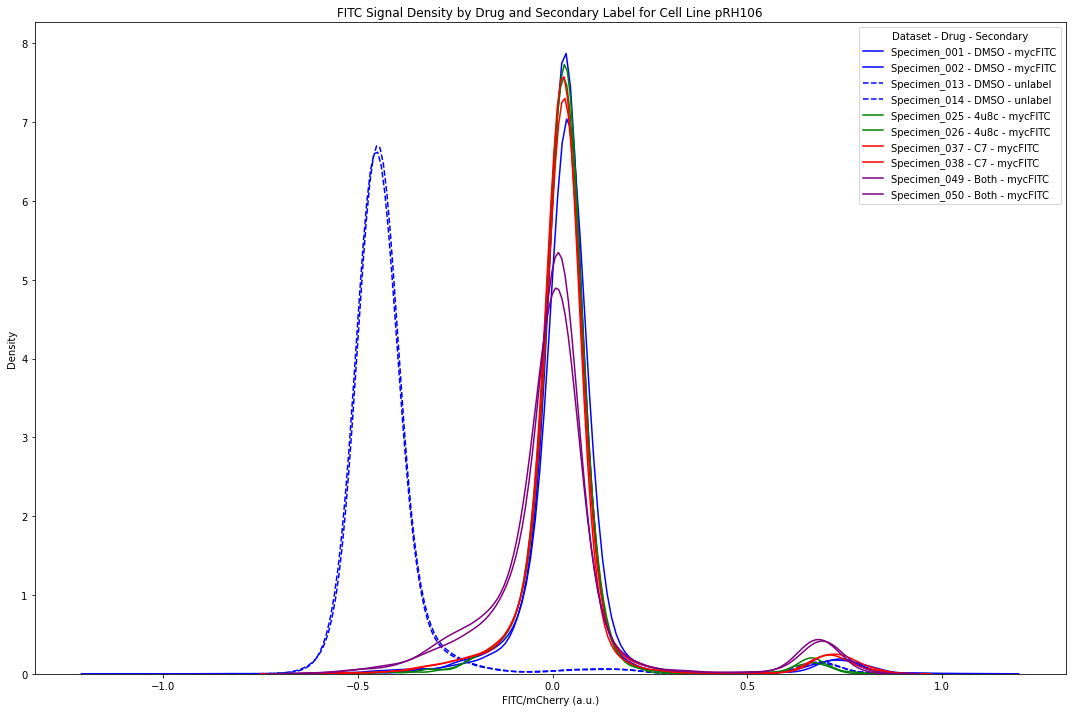

In [6]:
def plot_kde_fitc_by_drug_secondary(data_dict, cell_line_label,antibody):
    plt.figure(figsize=(15, 10))

    # Define a color palette for the drugs
    drug_colors = {'DMSO': 'blue', '4u8c': 'green', 'C7': 'red', 'Both': 'purple'}

    for key, df in data_dict.items():
        # Filter for 'cell_line' label
        filtered_df = df[df['cell_line'] == cell_line_label]

        if not filtered_df.empty:
            for drug in drug_colors.keys():
                drug_df = filtered_df[filtered_df['drug'] == drug]
                for secondary_label in drug_df['secondary'].unique():
                    sec_df = drug_df[drug_df['secondary'] == secondary_label]
                    if not sec_df.empty:
                        label = f'{key} - {drug} - {secondary_label}'
                        linestyle = '--' if secondary_label == 'unlabel' else '-'
                        sns.kdeplot(data=sec_df, x=antibody, label=label, 
                                    fill=False, color=drug_colors[drug], linestyle=linestyle)
                        
    plt.xlabel('FITC/mCherry (a.u.)')
    plt.ylabel('Density')
    plt.title('FITC Signal Density by Drug and Secondary Label for Cell Line {}'.format(cell_line_label))
    plt.legend(title='Dataset - Drug - Secondary')
    plt.tight_layout()
    
    #plt.savefig('flow_results_histo.png', dpi=300)

plot_kde_fitc_by_drug_secondary(combined_data_dict,'pRH106','Normalized (a.u.)')


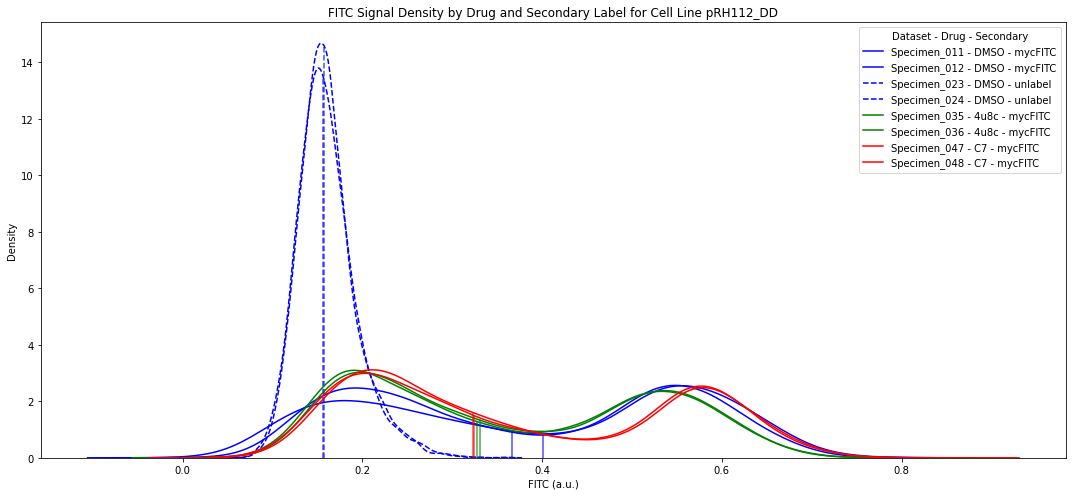

In [7]:
#adds a median line

def plot_kde_fitc_by_drug_secondary(data_dict, cell_line_label, antibody):
    plt.figure(figsize=(15, 7))

    # Define a color palette for the drugs
    drug_colors = {'DMSO': 'blue', '4u8c': 'green', 'C7': 'red', 'Both': 'purple'}

    for key, df in data_dict.items():
        # Filter for 'cell_line' label
        filtered_df = df[df['cell_line'] == cell_line_label]

        if not filtered_df.empty:
            for drug in drug_colors.keys():
                drug_df = filtered_df[filtered_df['drug'] == drug]
                for secondary_label in drug_df['secondary'].unique():
                    sec_df = drug_df[drug_df['secondary'] == secondary_label]
                    if not sec_df.empty:
                        label = f'{key} - {drug} - {secondary_label}'
                        linestyle = '--' if secondary_label == 'unlabel' else '-'
                        
                        # Plot the KDE
                        sns_kde = sns.kdeplot(data=sec_df, x=antibody, label=label, 
                                              fill=False, color=drug_colors[drug], linestyle=linestyle)

                        # Calculate and plot the median line up to the KDE curve
                        median_value = sec_df[antibody].median()
                        kde_values = sns_kde.get_lines()[-1].get_data()
                        kde_x, kde_y = kde_values
                        median_density = np.interp(median_value, kde_x, kde_y)
                        plt.plot([median_value, median_value], [0, median_density], color=drug_colors[drug], linestyle=linestyle, alpha=0.7)

    plt.xlabel('FITC (a.u.)')
    #plt.xlim(-0.1,1)
    plt.ylabel('Density')
    plt.title('FITC Signal Density by Drug and Secondary Label for Cell Line {}'.format(cell_line_label))
    plt.legend(title='Dataset - Drug - Secondary')
    plt.tight_layout()
    
    # Uncomment to save the figure
    plt.savefig('flow_results_histo_median.png', dpi=300)

# Example usage
plot_kde_fitc_by_drug_secondary(combined_data_dict, 'pRH112_DD', 'FITC (a.u.)')


In [8]:
normalized_data

,cell_line,drug,secondary,median_mCherry,sem_mCherry,median_FITC,sem_FITC,FITC_mCherry_ratio,error_ratio,FITC_mCherry_ratio_control,error_ratio_control,normalized_to_control,error_normalized_to_control
0,pRH106,4u8c,mycFITC,0.643172,0.032419,0.669681,0.028245,1.041217,0.068432,1.055431,0.075092,0.986532,0.095554
1,pRH106,Both,mycFITC,0.683685,0.043504,0.697787,0.040536,1.020626,0.087938,1.055431,0.075092,0.967023,0.108055
2,pRH106,C7,mycFITC,0.677469,0.037063,0.706942,0.033011,1.043504,0.075056,1.055431,0.075092,0.988700,0.100028
3,pRH106,DMSO,mycFITC,0.665447,0.036067,0.702333,0.032371,1.055431,0.075092,1.055431,0.075092,1.000000,0.100619
4,pRH108,4u8c,mycFITC,0.544997,0.038636,0.232636,0.036141,0.426857,0.072892,0.385914,0.067686,1.106093,0.270762
5,pRH108,Both,mycFITC,0.566898,0.042067,0.222605,0.036284,0.392672,0.070326,0.385914,0.067686,1.017511,0.255063
6,pRH108,C7,mycFITC,0.574245,0.038464,0.225513,0.035550,0.392712,0.067264,0.385914,0.067686,1.017617,0.249470
7,pRH108,DMSO,mycFITC,0.570993,0.037711,0.220354,0.035804,0.385914,0.067686,0.385914,0.067686,1.000000,0.248041
8,pRH108_DD,4u8c,mycFITC,0.561356,0.037939,0.233376,0.036402,0.415736,0.070672,0.391694,0.067287,1.061380,0.256510
9,pRH108_DD,Both,mycFITC,0.549384,0.039004,0.225969,0.036727,0.411312,0.072951,0.391694,0.067287,1.050086,0.259282


In [9]:
def normalize_FITC_to_DMSO_control(df, control_drug='DMSO'):
    # Extract control median FITC values for each cell line to use in normalization.
    control_medians = df[df['drug'] == control_drug][['cell_line', 'median_FITC', 'sem_FITC']].rename(columns={'median_FITC': 'median_FITC_control', 'sem_FITC': 'sem_FITC_control'})

    # Merge the control data with the main DataFrame for direct comparison.
    normalized_df = df.merge(control_medians, on='cell_line')

    # Calculate the normalized FITC value to control and its associated error.
    normalized_df['FITC_normalized_to_control'] = normalized_df['median_FITC'] / normalized_df['median_FITC_control']
    normalized_df['error_normalized_to_control'] = normalized_df['FITC_normalized_to_control'] * np.sqrt(
        (normalized_df['sem_FITC'] / normalized_df['median_FITC'])**2 + 
        (normalized_df['sem_FITC_control'] / normalized_df['median_FITC_control'])**2
    )

    return normalized_df

# Apply the new normalization function to the aggregated data.
FITC_normalized_data = normalize_FITC_to_DMSO_control(compressed_df, control_drug='DMSO')


In [12]:
FITC_normalized_data

,cell_line,drug,secondary,median_mCherry,sem_mCherry,median_FITC,sem_FITC,FITC_mCherry_ratio,error_ratio,median_FITC_control,sem_FITC_control,FITC_normalized_to_control,error_normalized_to_control
0,pRH106,4u8c,mycFITC,0.643172,0.032419,0.669681,0.028245,1.041217,0.068432,0.702333,0.032371,0.953509,0.059572
1,pRH106,Both,mycFITC,0.683685,0.043504,0.697787,0.040536,1.020626,0.087938,0.702333,0.032371,0.993526,0.073676
2,pRH106,C7,mycFITC,0.677469,0.037063,0.706942,0.033011,1.043504,0.075056,0.702333,0.032371,1.006562,0.066042
3,pRH106,DMSO,mycFITC,0.665447,0.036067,0.702333,0.032371,1.055431,0.075092,0.702333,0.032371,1.000000,0.065183
4,pRH108,4u8c,mycFITC,0.544997,0.038636,0.232636,0.036141,0.426857,0.072892,0.220354,0.035804,1.055734,0.237329
5,pRH108,Both,mycFITC,0.566898,0.042067,0.222605,0.036284,0.392672,0.070326,0.220354,0.035804,1.010214,0.232500
6,pRH108,C7,mycFITC,0.574245,0.038464,0.225513,0.035550,0.392712,0.067264,0.220354,0.035804,1.023413,0.231686
7,pRH108,DMSO,mycFITC,0.570993,0.037711,0.220354,0.035804,0.385914,0.067686,0.220354,0.035804,1.000000,0.229784
8,pRH108_DD,4u8c,mycFITC,0.561356,0.037939,0.233376,0.036402,0.415736,0.070672,0.227483,0.036256,1.025903,0.228781
9,pRH108_DD,Both,mycFITC,0.549384,0.039004,0.225969,0.036727,0.411312,0.072951,0.227483,0.036256,0.993342,0.226121


In [11]:
import scipy.stats as stats

def mann_whitney_test_by_group(df, group_column, comparison_column):
    unique_groups = df[group_column].unique()
    results = []

    for cell_line in unique_groups:
        cell_line_data = df[df[group_column] == cell_line]
        drugs = cell_line_data['drug'].unique()

        for i in range(len(drugs)):
            for j in range(i + 1, len(drugs)):
                drug1 = drugs[i]
                drug2 = drugs[j]

                data1 = cell_line_data[cell_line_data['drug'] == drug1][comparison_column]
                data2 = cell_line_data[cell_line_data['drug'] == drug2][comparison_column]

                # Perform the Mann-Whitney U test
                u_stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')

                results.append({
                    'cell_line': cell_line,
                    'drug1': drug1,
                    'drug2': drug2,
                    'U_statistic': u_stat,
                    'p_value': p_value
                })

    return pd.DataFrame(results)

# Using the function on your DataFrame
test_results = mann_whitney_test_by_group(FITC_normalized_data, 'cell_line', 'normalized_to_control')

# Displaying the results
print(test_results)


Empty DataFrame
Columns: []
Index: []


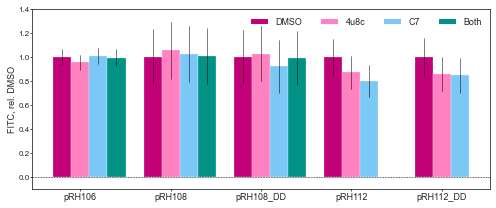

In [10]:
# Pivot your data to have 'cell_line' as rows and 'drug' as columns
pivoted_data = FITC_normalized_data.pivot(index='cell_line', columns='drug', values='FITC_normalized_to_control')
pivoted_error = FITC_normalized_data.pivot(index='cell_line', columns='drug', values='error_normalized_to_control')

# Define colors
DMSO_color = '#C20078'
fouru8c_color = '#FF81C0'
C7_color = '#7BC8F6'
Both_color = '#029386'

# Define the order in which to plot the drugs
drug_order = ['DMSO', '4u8c', 'C7', 'Both']

# Plotting setup
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,3))
plt.tick_params(size=2, labelsize=7, length=2.5, pad=1)
width = 0.2  # Width of the bars

# Iterate through cell lines and drugs for plotting
for xval, cell_line in enumerate(pivoted_data.index):
    for drug_index, drug in enumerate(drug_order):
        # Check if drug is present in the column
        if drug in pivoted_data.columns:
            value = pivoted_data.at[cell_line, drug]
            error = pivoted_error.at[cell_line, drug]
            
            # Only plot if the value is not NaN
            if not np.isnan(value):
                # Calculate the position for each bar
                position = xval - (1.5 * width) + (width * drug_index)

                # Choose the color based on the drug
                if drug == "DMSO":
                    color = DMSO_color
                elif drug == "4u8c":
                    color = fouru8c_color
                elif drug == "C7":
                    color = C7_color
                else:  # 'Both'
                    color = Both_color

                # Plot the bar and error bars
                plt.bar(position, value, width, color=color, linewidth=0.25)
                plt.plot([position, position], [value - error, value + error], 'k-', linewidth=0.5)

# Set x-ticks to be in the center of each group of bars
center_positions = np.arange(len(pivoted_data.index)) - (0.5 * width)
plt.xticks(center_positions, pivoted_data.index, fontsize=9, rotation=0, ha='center', rotation_mode="anchor")

# Y-axis label and legend
plt.yticks(fontsize=8)
plt.ylabel('FITC, rel. DMSO', labelpad=2, fontsize=9)
legend_elements = [Patch(facecolor=DMSO_color, label='DMSO'),
                   Patch(facecolor=fouru8c_color, label='4u8c'),
                   Patch(facecolor=C7_color, label='C7'),
                   Patch(facecolor=Both_color, label='Both')]
plt.legend(handles=legend_elements, fontsize=9, loc='upper right', ncol=4, frameon=False)

# Additional formatting
plt.axhline(y=0, linestyle='dashed', c='black', linewidth=0.5)
fmt = '%.1f'
plt.ylim(-0.1,1.4)
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)
plt.tight_layout()

# Save the figure as a high-quality PNG
#plt.savefig('flow_results.png', dpi=300)